# Laboratorio: Regressione Lineare

**Programmazione di Applicazioni Data Intensive**  
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Proff. Gianluca Moro, Roberto Pasolini  
`nome.cognome@unibo.it`

In [1]:
# test librerie
import numpy, pandas, matplotlib

## Analisi di regressione

- Un **_modello di regressione_** permette di ottenere una stima $\hat{y}$ del valore $y$ di una variabile _dipendente_ in base ai valori di una o più variabili _indipendenti_ $x_1,\ldots,x_n$
- Viene **addestrato** su osservazioni di cui si conoscono sia i valori $x_1,\ldots,x_n$ che $y$ in modo da minimizzare l'errore che compie su queste osservazioni
- Una volta addestrato, il modello può essere usato per effettuare **inferenze**, ovvero stime su nuovi dati e predizioni sul futuro
- La **regressione _lineare_** è un modello semplice ma spesso abbastanza efficace per ricavare modelli di predizione
- Possiamo implementare la regressione lineare tramite **_discesa gradiente_** con semplici operazioni tra vettori

### Caricamento librerie

- Per l'esercitazione utilizzeremo le librerie viste finora
  - _NumPy_ per creare e operare su array a N dimensioni
  - _pandas_ per caricare e manipolare dati tabulari
  - _matplotlib_ per creare grafici
- Importiamo subito tutte le librerie usando i loro alias convenzionali
  - abilitiamo inoltre l'inclusione dei grafici in Jupyter

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Caso di studio 1: Predizione del consumo di elettricità

- Per dimensionare adeguatamente le risorse, una compagnia elettrica deve predire giornalmente **quanta corrente sarà consumata** il giorno dopo
- Si ipotizza che nei mesi estivi una quota consistente di energia sia impiegata per l'aria condizionata
- La compagnia **incrocia quindi i dati storici** sul consumo con quelli sulla **temperatura** per indagare sul fenomeno...

### Caricamento dei dati

- Prendiamo come esempio i dati relativi all'area di Pittsburgh negli USA
  - la compagnia elettrica rende disponibili dati storici sul consumo quì: https://dataminer2.pjm.com/feed/hrl_load_metered/definition
  - i dati sulle temperature registrate possono invece essere reperiti da quì: https://shawxiaozhang.github.io/wefacts/
- Abbiamo raccolto i dati utili dal 2015 al 2017 in un file CSV con colonne:
  - `data`: data (in formato standard YYYY-MM-DD)
  - `demand`: picco di consumo (in gigawatt, GW)
  - `temp`: temperatura media (in gradi Celsius, °C)
- Eseguire la seguente cella per scaricare il file localmente

In [3]:
import os.path
if not os.path.exists("power.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://git.io/vpaM1", "power.csv")

- Usiamo pandas per caricare i dati in un DataFrame dato l'URL del file
  - col parametro `parse_dates` si indica a pandas di interpretare i valori di una o più colonne indicate come date invece che come semplici stringhe: questo rende possibili operazioni specifiche per le date

In [4]:
data = pd.read_csv("power.csv", parse_dates=["date"])

In [5]:
data.head(3)

,date,demand,temp
0,2015-01-01,1.736065,1.7
1,2015-01-02,1.831672,2.2
2,2015-01-03,1.714934,14.4


In [6]:
data.tail(3)

,date,demand,temp
1093,2017-12-29,1.940514,-7.8
1094,2017-12-30,1.909027,-7.8
1095,2017-12-31,1.937984,-10.6


- Le colonne `demand` e `temp` contengono i dati veri e propri, mentre `date` indica la data a cui ciascuna riga si riferisce
- Ha senso quindi che `date` sia l'indice del DataFrame
- In `read_csv` possiamo usare l'opzione `index_col` per specificare che una o più colonne costituiscano l'indice del DataFrame

In [7]:
# data = pd.read_csv("power.csv", parse_dates=["date"], index_col="date")

- In alternativa usiamo `set_index` sul DataFrame già caricato per impostare una colonna come indice
  - `inplace=True` specifica di modificare il DataFrame senza crearne una copia

In [8]:
data.set_index("date", inplace=True)

In [9]:
data.head(3)

,demand,temp
date,,
2015-01-01,1.736065,1.7
2015-01-02,1.831672,2.2
2015-01-03,1.714934,14.4


### Selezione dei dati

- Il dataset contiene i dati relativi agli interi anni tra il 2015 e il 2017, ma la nostra analisi è limitata (per il momento) ai mesi estivi
- Vogliamo selezionare dal DataFrame le sole righe relative a giugno, luglio e agosto di ciascun anno
- L'attributo `index` del DataFrame ci permette di accedere alle date delle singole righe
- Per indici di tipo data/ora come questo, pandas offre attributi per selezionare un singolo campo di tutte le date
- Selezioniamo quindi il mese (da 1 a 12) di ciascuna data con `index.month`
  - oltre a `month` esistono `year`, `day`, `hour`, ...

In [10]:
data.index.month

Int64Index([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
            ...
            12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
           dtype='int64', name='date', length=1096)

- Possiamo ottenere un array che indica per quali dati il mese è compreso tra 6 (giugno) e 8 (agosto)

In [11]:
(data.index.month >= 6) & (data.index.month <= 8)

array([False, False, False, ..., False, False, False])

- Possiamo quindi selezionare le righe di `data` che corrispondono a questa condizione
- Usiamo la selezione delle righe per posizione con `iloc`

In [12]:
data_summer = data.iloc[(data.index.month >= 6) & (data.index.month <= 8)]

- Alternativa: il metodo `isin` verifica per ciascun valore di una serie, frame o indice la presenza in una collezione data

In [13]:
data_summer = data.iloc[data.index.month.isin([6, 7, 8])]

- `data_summer` ha quindi le stesse colonne di `data` ma contiene solamente le righe d'interesse

In [14]:
data_summer.head(3)

,demand,temp
date,,
2015-06-01,1.640036,15.6
2015-06-02,1.663211,17.2
2015-06-03,1.728381,21.7


In [15]:
data_summer.tail(3)

,demand,temp
date,,
2017-08-29,1.845325,23.9
2017-08-30,1.911302,25.0
2017-08-31,1.913172,24.4


### Esercizio 1: Analisi esplorativa

Analizzare i dati nel frame `data_summer` appena ottenuto
- **(1a)** Ottenere le statistiche generali sulle due variabili `temp` e `demand` (media, estremi, quartili, ...)
- **(1b)** Visualizzare la distribuzione delle due variabili in degli istogrammi
- **(1c)** Visualizzare la distribuzione congiunta delle due variabili in un grafico di dispersione

In [16]:
data_summer.describe()

,demand,temp
count,276.000000,276.000000
mean,2.184207,27.335507
std,0.308225,3.164825
min,1.496912,15.600000
25%,1.939613,25.000000
50%,2.196759,27.800000
75%,2.430171,29.400000
max,2.804025,33.900000


In [17]:
data_summer["temp"].describe()

count    276.000000
mean      27.335507
std        3.164825
min       15.600000
25%       25.000000
50%       27.800000
75%       29.400000
max       33.900000
Name: temp, dtype: float64

In [18]:
data_summer["demand"].describe()

count    276.000000
mean       2.184207
std        0.308225
min        1.496912
25%        1.939613
50%        2.196759
75%        2.430171
max        2.804025
Name: demand, dtype: float64

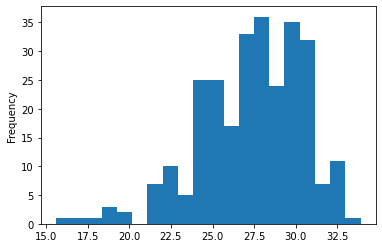

In [19]:
data_summer["temp"].plot.hist(bins=20);

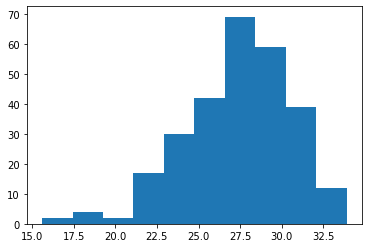

In [20]:
plt.hist(data_summer["temp"]);

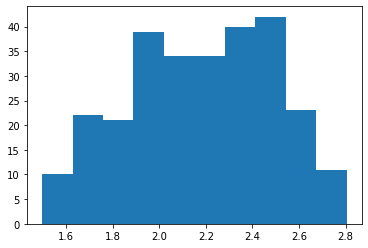

In [21]:
plt.hist(data_summer["demand"]);

C:\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


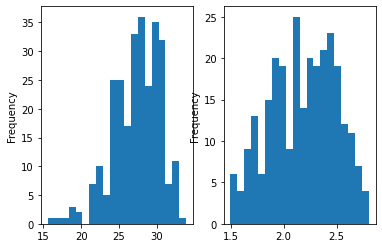

In [22]:
data_summer["temp"].plot.hist(bins=20, ax=plt.subplot(1,2,1));
data_summer["demand"].plot.hist(bins=20, ax=plt.subplot(1,2,2));

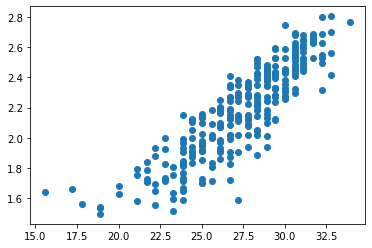

In [23]:
plt.scatter(data_summer["temp"],data_summer["demand"]);

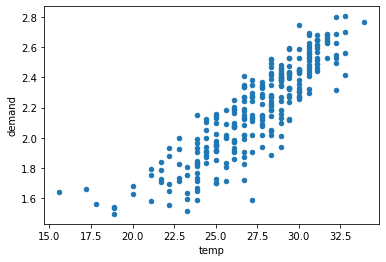

In [24]:
data_summer.plot.scatter("temp","demand");

## Correlazione tra variabili

- Il grafico a dispersione suggerisce che esista una correlazione tra le due variabili
  - a valori alti (o bassi) della temperatura corrispondono valori alti (o bassi) del consumo
- Come possiamo quantificare questa correlazione?
- Il _coefficiente di correlazione di Pearson_ è un indice usato per valutare numericamente il grado di correlazione tra due variabili X e Y
- Il suo valore è compreso tra -1 e 1
  - valori vicini a 1 indicano correlazione diretta (Y cresce al crescere di X)
  - valori vicini a -1 indicano correlazione inversa (Y descresce al crescere di X)
  - valori vicini a 0 indicano assenza di correlazione
- Date due variabili casuali $X$ e $Y$, il coefficiente è il rapporto tra la loro covarianza $\sigma_{XY}$ e il prodotto delle deviazioni standard $\sigma_X$ e $\sigma_Y$
$$ \rho(X,Y) = \frac{\sigma_{XY}}{\sigma_X\sigma_Y} $$

- Data una serie di campioni $(x_1,y_1),\ldots,(x_n,y_n)$ delle due variabili con medie $\mu_X$ e $\mu_Y$, la correlazione si può stimare come
$$ (1)\,\,\,\,\frac{\sum_{i=1}^n{(x_i-\mu_X)\cdot(y_i-\mu_Y)}}{n\cdot\sigma_X\cdot\sigma_Y} $$
- Per brevità, estraiamo i due vettori di valori dal frame ed assegniamoli a due variabili
  - con `values` otteniamo solamente i valori delle serie, in forma di array NumPy

In [25]:
temp = data_summer["temp"].values
demand = data_summer["demand"].values

- Usiamole quindi per calcolare la formula sopra

In [26]:
np.mean((temp-temp.mean()) * (demand-demand.mean())) / (temp.std() * demand.std()) # (1)

0.876026184463451

- Come alternativa possiamo usare la funzione `corrcoef` di NumPy, che restituisce una matrice con tutte le correlazioni tra un numero arbitrario di variabili
  - NumPy si aspetta i valori di ciascuna variabile lungo una riga piuttosto che una colonna: trasponiamo il DataFrame (`.T`) per ottenere tale formato
  - gli 1 nella matrice corrispondono alla correlazione di ciascuna delle due variabili `temp` e `demand` con se stessa

In [27]:
np.corrcoef(data_summer.T)

array([[1.        , 0.87602618],
       [0.87602618, 1.        ]])

- Il valore ottenuto conferma che esiste una forte correlazione tra le due variabili

## Regressione lineare univariata

- Con i dati disponibili, possiamo creare un modello di regressione per ottenere una stima $\hat{y}$ del consumo di corrente $y$ in base alla temperatura (prevista) $x$
- Dovendo prevedere il valore della variabile dipendente $y$ in base ad un'unica variabile indipendente $x$, la regressione è _univariata_
- La regressione lineare univariata genera un modello con due parametri $\alpha$ (coefficiente angolare) e $\beta$ (_intercetta_)
$$ \hat{y} = h(x) = \alpha\cdot x+\beta $$
- L'obiettivo dell'analisi di regressione è trovare i valori di $\alpha$ e $\beta$ per cui il modello $h(x)$ approssimi quanto meglio possibile la correlazione tra consumi e temperatura

### Esempio di modello di regressione

- Si ipotizzi ad esempio di impostare arbitrariamente i parametri a $\alpha=0.2,\beta=-3$
- La funzione che approssima il consumo in base alla temperatura $x$ sarebbe $h(x)=0.2\cdot x-3$
- Possiamo definire tale funzione in Python:

In [28]:
def sample_model(x):
    return 0.2 * x - 3

- Ad es. per una temperatura di 25 °C sarebbe previsto un picco di consumi in GW di:

In [29]:
sample_model(25)   # = 0.2 * 25 - 3 =

2.0

- Dato che gli operatori sono compatibili, tale funzione si può applicare per vettori: passando come argomento un vettore di valori X otteniamo un vettore di corrispondenti valori Y

In [30]:
sample_model(np.array([20, 25, 30]))

array([1., 2., 3.])

- Per comodità, creiamo una funzione di _ordine superiore_, che dati i parametri `alpha` e `beta` restituisca a sua volta una funzione che implementa il modello con tali parametri

In [31]:
def make_model(alpha, beta):
    # creo una funzione...
    def model(x):
        return alpha * x + beta
    # ...e la restituisco
    return model

- Ad es., per ottenere il modello dell'esempio precedente:

In [32]:
sample_model = make_model(0.2, -3)

In [33]:
sample_model(25)

2.0

In [34]:
sample_model(np.array([20, 25, 30]))

array([1., 2., 3.])

In [35]:
make_model(0.2,-3)(25)

2.0

- Si noti che va creato esplicitamente un array NumPy, altrimenti si ha errore perché le liste Python non supportano le stesse operazioni
- Come alternativa si può usare la funzione `vectorize` di NumPy che trasforma una funzione data in modo da convertire automaticamente in array i suoi input e output
  - `vectorize` è un altro esempio di funzione di ordine superiore: prende in input una funzione e ne restituisce un'altra

In [36]:
sample_model_vec = np.vectorize(sample_model)

In [37]:
sample_model_vec(25)

array(2.)

In [38]:
sample_model_vec([20, 25, 30])

array([1., 2., 3.])

### Grafico del modello di regressione

- Un modello di regressione lineare univariata $h(x)=\alpha\cdot x+\beta$ è rappresentabile come una retta in un piano
- Possiamo quindi disegnare un grafico di tale modello
- Come metodo generale per disegnare il grafico di una funzione in matplotlib, generiamo un vettore di valori di x possibili e applichiamo ad esso la funzione per ottenere i corrispondenti valori y
- Creiamo un vettore di N valori x distribuiti linearmente in un intervallo con la funzione `linspace` di NumPy e un vettore dei corrispondenti valori y

In [39]:
plot_x = np.linspace(15, 35, 100)
plot_y = sample_model(plot_x)

- Usiamo quindi la funzione `plot` di matplotlib per tracciare il grafico, passando il vettore di x e le y corrispondenti
  - il grafico viene tracciato congiungendo i campioni dati della funzione
  - essendo una retta sarebbero bastati i due punti estremi, ma questo approccio funziona anche su curve

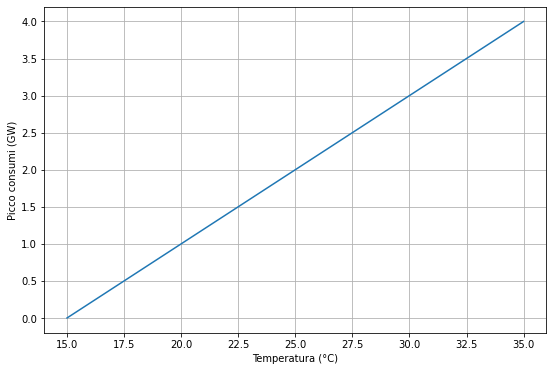

In [40]:
plt.figure(figsize=(9, 6))
plt.plot(plot_x, plot_y)

# aggiungo linee guida lungo entrambi gli assi
plt.grid()

# assegno etichette comprensibili agli assi
plt.xlabel("Temperatura (°C)")
plt.ylabel("Picco consumi (GW)");

- Il grafico conferma ad es. come visto sopra che a fronte di una temperatura di 25 °C il modello prevede 2 GW di consumi

- Per avere un'idea di quanto il modello sia accurato, possiamo sovrapporlo al grafico a dispersione dei dati
  - introduciamo parte dell'API ad oggetti di matplotlib, ci tornerà utile per creare figure con più grafici
  - ci accertiamo che il grafico sia "zoomato" sui dati, lasciando fuori parte della retta se necessario

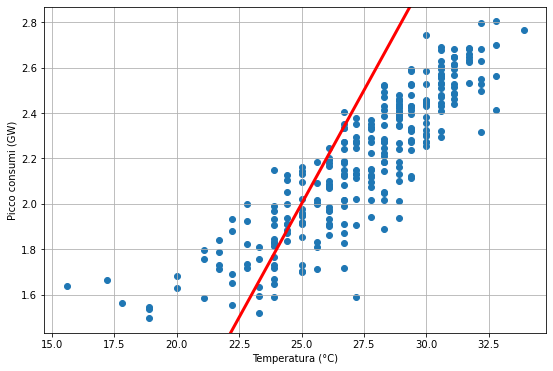

In [41]:
# inizializzo la figura indicando le dimensioni
plt.figure(figsize=(9, 6))

# la figura di default contiene un singolo grafico, uso la funzione
# gca ("Get Current Axes") per ottenerlo come oggetto
ax = plt.gca()
# sull'oggetto Axes posso invocare molte delle funzioni invocabili da plt

# disegno un grafico a dispersione dei dati
ax.scatter(temp, demand)

# estraggo i limiti calcolati per il grafico
xlim = ax.get_xlim()  # -> tupla (X minima, X massima)
ylim = ax.get_ylim()  # -> tupla (Y minima, Y massima)

# traccio la retta del modello sovrapposta ai dati
ax.plot(plot_x, plot_y, lw=3, c="red")

# reimposto i limiti del grafico a quelli calcolati sui dati
# (se rimuovo queste istruzioni, il grafico viene schiacciato
# per contenere tutti i campioni della retta)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# personalizzo il grafico aggiungendo griglia e etichette degli assi
# lavorando su un oggetto Axes "xlabel"/"ylabel" diventano "set_xlabel"/"set_ylabel"
ax.grid()
ax.set_xlabel("Temperatura (°C)")
ax.set_ylabel("Picco consumi (GW)");

- Definiamo una funzione che produca tale grafico su dei dati e su un modello (opzionale) arbitrari passati come parametri
  - diamo la possibilità di passare un oggetto Axes (`ax`) per disegnare il grafico su di esso, creandone uno nuovo di default: lo stesso principio è utilizzato nelle funzioni `plot.*` di serie e DataFrame

In [42]:
def plot_model_on_data(x, y, model=None, title=None, ax=None):
    if ax is None:
        plt.figure(figsize=(9, 6))
        ax = plt.gca()
    ax.scatter(x, y)
    if model is not None:
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        plot_x = np.linspace(xlim[0], xlim[1], 100)
        plot_y = model(plot_x)
        ax.plot(plot_x, plot_y, lw=3, c="red")
        ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.grid()
    ax.set_title(title)
    ax.set_xlabel("Temperatura (°C)")
    ax.set_ylabel("Picco consumi (GW)")

- In questo modo possiamo ottenere il grafico desiderato semplicemente con:

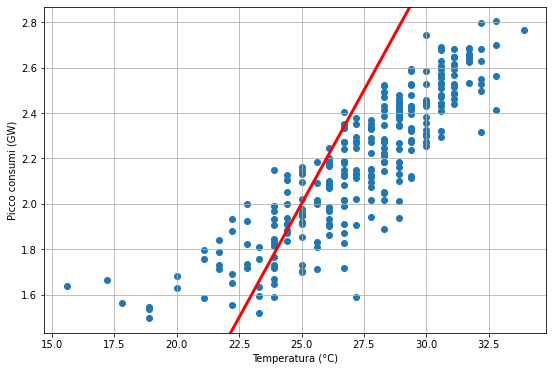

In [43]:
plot_model_on_data(temp, demand, sample_model)

- Confrontando ad occhio il modello con i dati reali, si può vedere che le predizioni non sono accurate, in particolare per temperature vicino agli estremi

## Errore del modello

- Come quantificare l'errore che un modello $h$ compie rispetto ai dati reali?
- La metrica usata più comunemente è l'_errore quadratico medio_ (_mean squared error_, MSE), ovvero la media dei quadrati delle differenze tra ciascun valore reale $y_j$ e la corrispondente predizione $\hat{y_j}=h(x_j)$
$$ E=\frac{1}{m}\sum_{j=1}^m\left(h(x_j)-y_j\right)^2 $$
- In forma vettoriale:
$$ E=\mathrm{media}\left(\left(\mathbf{\hat{y}}-\mathbf{y}\right)^2\right) $$

- Ad esempio, calcoliamo l'errore del modello considerato sopra con parametri $\alpha=0.2,\beta=-3$
- Otteniamo le predizioni del modello (ovvero il vettore $\mathbf{\hat{y}}$)

In [44]:
predicted_demand = sample_model(temp)

- Per ogni predizione, l'errore è dato dalla differenza rispetto al valore reale (`demand`)

In [45]:
error = predicted_demand - demand

- Applichiamo quindi la formula per calcolare il MSE

In [46]:
#  Mean     Squared Error
np.mean( np.square( error ) )

0.23330138712973206

- Questo valore può essere confrontato con quello di altri modelli: minore è l'errore, più accurato è il modello

### Esercizio 2: Modelli ed errore

Usare le funzioni definite sopra per:
- **(2a)** creare un modello di regressione univariata lineare con $\alpha=0.15$ e $\beta=-1$
- **(2b)** predire i consumi di energia a fronte di temperature di 20, 25 e 30 °C
- **(2c)** visualizzare tale modello come linea in un grafico, sovrapposto al grafico a dispersione dei dati
- **(2d)** calcolare l'errore quadratico medio compiuto dal modello e valutare se sia più o meno accurato di quello sopra

In [47]:
model_2 = make_model(0.15, -1)
model_2_vec = np.vectorize(model_2)

In [48]:
model_2_vec([20,25,30])

array([2.  , 2.75, 3.5 ])

In [49]:
#plot_model_on_data(temp, demand, model_2, "Model 2")

In [50]:
np.mean(np.square(model_2(temp)-demand))

0.9030444487239344

### Errore in funzione dei parametri

- Riprendiamo la formula dell'errore quadratico medio di un modello $h(x)$ su un insieme di dati $(x_1,y_1),\ldots,(x_m,y_m)$:
$$ E=\frac{1}{m}\sum_{j=1}^m\left(h(x_j)-y_j\right)^2 $$
- Rendendo esplicita la formula del modello $h(x)=\alpha\cdot x+\beta$, possiamo esprimere l'errore in funzione dei parametri del modello $\alpha$ e $\beta$
  - i dati $(x_1,y_1),\ldots,(x_m,y_m)$ su cui l'errore è calcolato sono fissati a priori
$$ E(\alpha,\beta)=\frac{1}{m}\sum_{j=1}^m\left(\alpha\cdot x_j+\beta-y_j\right)^2 $$
- Scritto in forma vettoriale:
$$ E(\alpha,\beta)=\mathrm{media}\left(\left(\alpha\cdot\mathbf{x}+\beta-\mathbf{y}\right)^2\right) $$

- Ad esempio, riprendendo il modello d'esempio con parametri $\alpha=0.2,\beta=-3$, possiamo calcolarne il MSE con:

In [51]:
np.mean(np.square(0.2 * temp - 3 - demand))

0.23330138712973206

- Il risultato è lo stesso ottenuto sopra col calcolo sulla funzione `sample_model`
- Possiamo definire una funzione Python che calcoli l'errore dati i parametri `alpha` e `beta`

In [52]:
# Uniform Linear Regression _ Mean Squared Error
def ulr_mse(x, y, alpha, beta):
    return np.mean(np.square(alpha * x + beta - y))

- Testiamo la funzione sui parametri d'esempio

In [53]:
ulr_mse(temp, demand, 0.2, -3)

0.23330138712973206

- Possiamo riscrivere questa funzione per accettare _array_ di valori di `alpha` e `beta` e restituire corrispondenti array di valori del MSE
- `np.expand_dims(x, -1)` accetta uno scalare o un array `x` di qualsiasi forma `(*)` e aggiunge una dimensione per dargli forma `(*, 1)`
  - ad es., sia `x` un vettore, `np.expand_dims(x, -1) == x[:, None]`
- Sono calcolati gli errori per tutte le combinazioni di `(alpha, beta)` e `(x, y)` sfruttando le regole di broadcasting di NumPy
$$\begin{bmatrix}\alpha_1\\\vdots\\\alpha_n\end{bmatrix}\cdot\begin{bmatrix}x_1&\cdots&x_m\end{bmatrix}+\begin{bmatrix}\beta_1\\\vdots\\\beta_n\end{bmatrix}-\begin{bmatrix}y_1&\cdots&y_m\end{bmatrix}=\begin{bmatrix}\alpha_1\cdot x_1+\beta_1-y_1&\cdots&\alpha_1\cdot x_m+\beta_1-y_m\\\vdots&\ddots&\vdots\\\alpha_n\cdot x_1+\beta_n-y_1&\cdots&\alpha_n\cdot x_m+\beta_n-y_m\end{bmatrix}$$
- La media è calcolata solo lungo l'ultima dimensione (`axis=-1`), senza aggregare i risultati di parametri diversi
$$\mathrm{mean}\left(\begin{bmatrix}e_{1,1}&\cdots&e_{1,m}\\\vdots&\ddots&\vdots\\e_{n,1}&\cdots&e_{n,m}\end{bmatrix},-1\right)=\begin{bmatrix}\mathrm{mean}\left(\begin{bmatrix}e_{1,1}&\cdots&e_{1,m}\end{bmatrix}\right)\\\vdots\\\mathrm{mean}\left(\begin{bmatrix}e_{n,1}&\cdots&e_{n,m}\end{bmatrix}\right)\end{bmatrix}$$

In [54]:
#expand_dims = converte un array numpy in un array colonna, se alpha è una variabile ritorna alpha
def ulr_mse(x, y, alpha, beta):
    alpha = np.expand_dims(alpha, -1)
    beta = np.expand_dims(beta, -1)
    return np.mean(np.square(alpha * x + beta - y), axis=-1)

- La nuova funzione è utilizzabile sia per valori singoli dei parametri che per vettori

In [55]:
# unico set di parametri: alpha=0.2, beta=-3
ulr_mse(temp, demand, 0.2, -3)

0.23330138712973206

In [56]:
# set 1: alpha=0.2, beta=-3
# set 2: alpha=0.15, beta=-1
ulr_mse(temp, demand, [0.2, 0.15], [-3, -1])

array([0.23330139, 0.90304445])

### Grafico della funzione d'errore

- Visualizziamo l'errore in funzione dei parametri in un grafico 3D
  - due dimensioni rappresentano i parametri, la terza l'errore
- Come per il grafico 2D sopra, estraiamo un insieme di campioni della funzione per visualizzarne il grafico
- Per prima cosa, usiamo `linspace` per definire campioni di valori per i parametri $\alpha$ (alpha) e $\beta$ (beta) singolarmente

In [57]:
plot_alpha = np.linspace(-.3, .3, 101)
plot_beta = np.linspace(-4, 4, 101)

- Usiamo quindi la funzione `ulr_mse` per calcolare l'errore per tutte le combinazioni possibili di valori di $\alpha$ e $\beta$
  - riformiamo i vettori a matrici 2D, le cui dimensioni corrispondono a valori di $\alpha$ e valori di $\beta$
  - otteniamo una matrice 2D con il MSE per ogni combinazione dei parametri

In [58]:
plot_mse = ulr_mse(temp, demand, plot_alpha[:, None], plot_beta[None, :])

- Otteniamo una matrice con una riga per ogni valore di $\alpha$ e una colonna per ogni valore di $\beta$

In [59]:
plot_mse.shape

(101, 101)

- Abilitiamo la creazione di grafici 3D in matplotlib tramite il seguente import

In [60]:
from mpl_toolkits import mplot3d

- Usiamo quindi l'API ad oggetti di matplotlib per creare il grafico
  - il metodo `subplot` della figura restituisce un grafico che occupa l'intera figura, impostato come 3D
  - il metodo `plot_wireframe` del grafico disegna la funzione date 3 matrici 2D con rispettivamente le coordinate X, Y e Z dei campioni della funzione
  - i parametri `rstride` e `cstride` controllano quanto sono fitte le curve che delineano la superficie della funzione

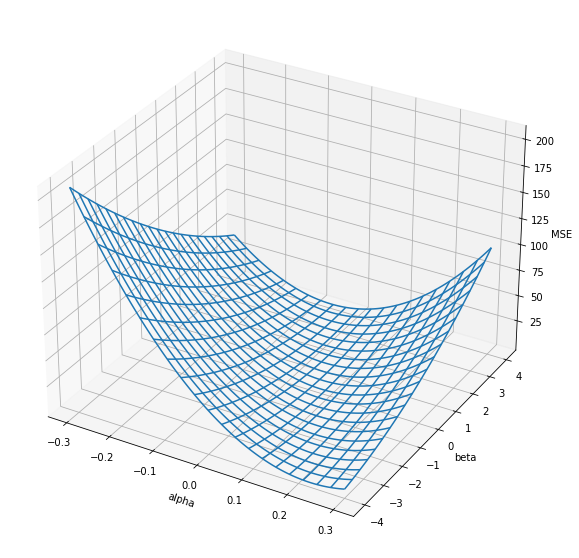

In [61]:
plt.figure(figsize=(10, 10))
ax = plt.subplot(projection="3d")
ax.plot_wireframe(plot_alpha[:, None], plot_beta[None, :], plot_mse, rstride=5, cstride=5)
ax.set_xlabel("alpha")
ax.set_ylabel("beta")
ax.set_zlabel("MSE");

- Si può notare come esista **un minimo** nella curva dell'errore e come il valore dell'errore cresca allontanandosi da tale minimo

## Discesa del gradiente

- Il _gradiente_ di una funzione indica la direzione in cui la curva della funzione stessa è maggiormente "inclinata"
  - il gradiente è il vettore delle _derivate parziali_ per ogni variabile
- Ad esempio il gradiente della funzione errore riportata sopra in funzione di $\alpha$ e $\beta$ è dato da:
$$ \nabla E(\alpha,\beta)=\left(\frac{\delta E}{\delta\alpha},\frac{\delta E}{\delta\beta}\right) $$
$$ \frac{\delta E}{\delta\alpha}=\frac{2}{m}\sum_{j=1}^m(\alpha\cdot x_j+\beta-y_j)\cdot x_j \qquad \frac{\delta E}{\delta\beta}=\frac{2}{m}\sum_{j=1}^m(\alpha\cdot x_j+\beta-y_j) $$
- L'algoritmo di _discesa del gradiente_, partendo da valori arbitrari di $\alpha$ e $\beta$, segue progressivamente il gradiente di $E$ per trovarne il minimo
- Fissata una lunghezza del passo $\eta$, ad ogni passaggio $\alpha$ e $\beta$ sono iterativamente aggiornati come segue:
$$ \alpha\leftarrow\alpha-\eta\cdot\frac{\delta E}{\delta\alpha} \qquad \beta\leftarrow\beta-\eta\cdot\frac{\delta E}{\delta\beta} $$
- In termini vettoriali, ponendo $\theta=(\alpha,\beta)$:
$$ \theta\leftarrow\theta-\eta\cdot\nabla E(\theta) $$

- Definiamo in Python una funzione `ulr_gd_step` che esegua un singolo passaggio della discesa gradiente
  - in ingresso sono passati i vettori dei dati x e y, i valori di $\alpha$ e $\beta$ attuali e la lunghezza del passo
  - la derivata dell'errore viene calcolata sui parametri dati
  - i nuovi valori di $\alpha$ e $\beta$ sono calcolati e restituiti

In [62]:
def ulr_gd_step(x, y, alpha, beta, step_size):

    # calcolo il vettore degli errori nei dati
    #       (   y predetta   ) - y reale
    error = (alpha * x + beta) - y

    # calcolo le derivate parziali del MSE
    d_alpha = 2 * (error * x).mean()
    d_beta = 2 * error.mean()

    # calcolo e restituisco alpha e beta aggiornati
    new_alpha = alpha - step_size * d_alpha
    new_beta = beta - step_size * d_beta
    return new_alpha, new_beta

- Usiamo ora questa funzione in un ciclo per eseguire una discesa completa
- Partiamo da valori di $\alpha$ e $\beta$ arbitrari

In [63]:
alpha = 0
beta = 0

- Per verificare in seguito la progressione della discesa, creiamo delle liste che conterrano in sequenza i valori di $\alpha$ e $\beta$ testati, compresi i valori iniziali

In [64]:
alpha_vals = [alpha]
beta_vals = [beta]

### Esercizio 3: Regressione univariata con discesa del gradiente

- **(3a)** Eseguire 20 iterazioni di discesa del gradiente con passo 0.001
  - ad ogni ciclo, sostituire i valori di `alpha` e `beta` ed aggiungere i valori nuovi alle liste `*_vals`
- **(3b)** Stampare i valori finali di `alpha` e `beta`
- **(3c)** Creare un modello basato sui valori finali di `alpha` e `beta`
- **(3d)** Visualizzare il grafico del modello sovrapposto ai dati
- **(3e)** Calcolare l'errore quadratico medio del modello

In [65]:
eta = 0.001
alpha = 0
beta = 0
alpha_vals = [alpha]
beta_vals = [beta]
for iteration in range(10):
    alpha, beta = ulr_gd_step(temp, demand, alpha, beta, eta)
    alpha_vals.append(alpha)
    beta_vals.append(beta)

In [66]:
print(f"alpha = {alpha}\nbeta = {beta}")

alpha = 0.07976455089011326
beta = 0.0028398135671445297


In [67]:
best = make_model(alpha, beta)

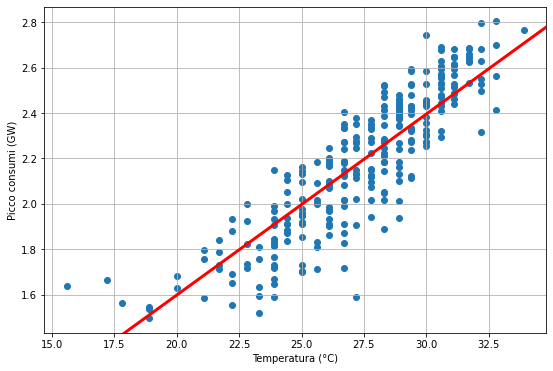

In [68]:
plot_model_on_data(temp, demand, best)

In [69]:
ulr_mse(temp, demand, alpha, beta)

0.022324135072073835

In [70]:
np.mean((best(temp)-demand)**2)

0.022324135072073835

### Progressione della discesa gradiente

- L'errore che otteniamo è l'_ottimo_ individuato tramite la discesa gradiente
- Ogni passaggio della discesa ha ridotto il MSE gradualmente fino a convergere ai valori finali
- Per verificare ciò, convertiamo le progressioni dei valori di $\alpha$ e $\beta$ in vettori e calcoliamo da questi la progressione del MSE

In [71]:
mse_vals = ulr_mse(temp, demand, alpha_vals, beta_vals)

- Visualizziamo in un grafico l'andamento del MSE
  - la stringa `"ro-"` indica lo stile del grafico: linea (`-`) rossa (`r`) con punti (`o`)

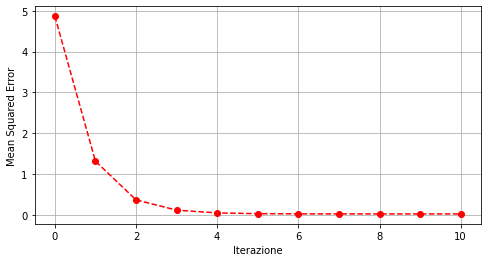

In [72]:
plt.figure(figsize=(8, 4))
plt.plot(mse_vals, "ro--")
plt.grid()
plt.xlabel("Iterazione")
plt.ylabel("Mean Squared Error");

- Per visualizzare meglio l'andamento per valori piccoli, applichiamo una scala logaritmica all'asse Y, usando la funzione `semilogy` al posto di `plot`

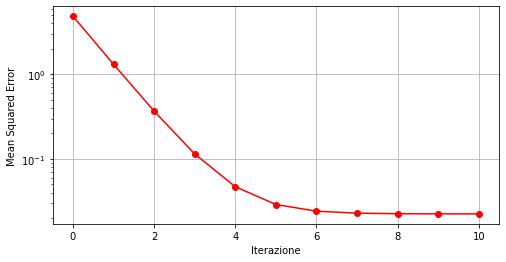

In [73]:
plt.figure(figsize=(8, 4))
plt.semilogy(mse_vals, "ro-")
plt.grid()
plt.xlabel("Iterazione")
plt.ylabel("Mean Squared Error");

- Vediamo tale progressione anche sul grafico 3D dell'errore, evidenziando (in rosso) i parametri testati da un passaggio all'altro e i corrispondenti MSE
  - cambiamo gli intervalli di valori `plot_alpha` e `plot_beta` per "zoomare" sul grafico

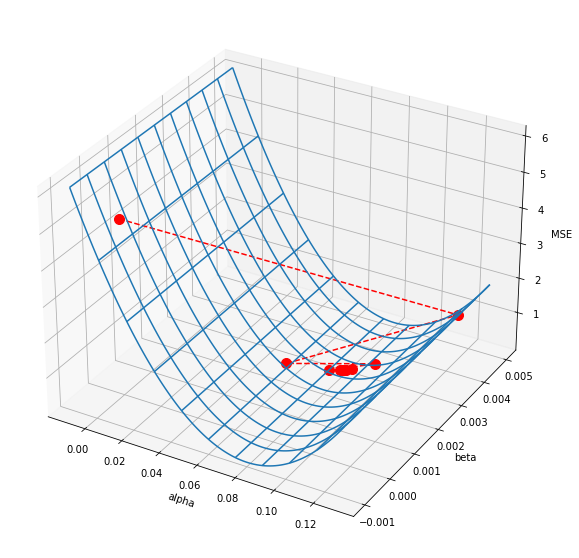

In [74]:
plot_alpha = np.linspace(-0.01, 0.13, 101)
plot_beta = np.linspace(-0.001, 0.005, 101)
plot_mse = ulr_mse(temp, demand, plot_alpha[:, None], plot_beta[None, :])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.plot_wireframe(plot_alpha[:,None], plot_beta[None,:], plot_mse, rstride=10, cstride=10)
ax.plot(alpha_vals, beta_vals, mse_vals, "o--", c="red", markersize=10)
ax.set_xlabel("alpha"); ax.set_ylabel("beta"); ax.set_zlabel("MSE");

- Possiamo usare in alternativa una visualizzazione 2D, dove le zone più scure corrispondono ad errore maggiore

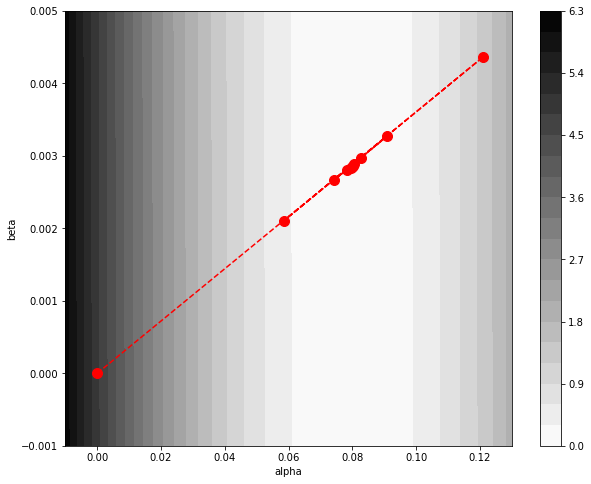

In [75]:
plt.figure(figsize=(10, 8))
plt.contourf(plot_alpha, plot_beta, plot_mse.T, levels=20, cmap="gray_r")
plt.colorbar()
plt.plot(alpha_vals, beta_vals, "ro--", markersize=10)
plt.xlabel("alpha")
plt.ylabel("beta");

- Si può vedere come, partendo da un punto arbitrario, con la discesa gradiente ci siamo progressivamente avvicinati al punto con errore minimo

- Possiamo infine vedere i grafici dei modelli ottenuti nei passaggi intermedi della discesa gradiente per vedere come la retta del modello si sovrapponga sempre meglio ai dati
- Usiamo la funzione `plot_model_on_data` in un ciclo per generare una figura con più grafici
  - la funzione `plt.subplot(R, C, N)` restituisce un oggetto Axes con la N-esima porzione della figura corrente suddividendola in R righe e C colonne

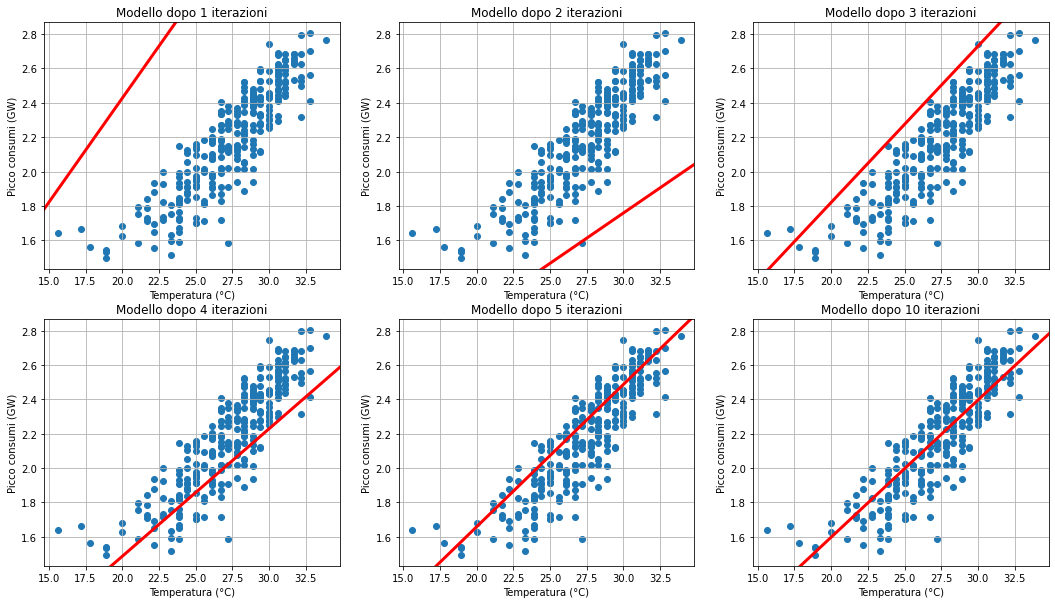

In [76]:
plt.figure(figsize=(18, 10))
for n, it in enumerate([1, 2, 3, 4, 5, 10], start=1):
    axes = plt.subplot(2, 3, n)
    temp_model = make_model(alpha_vals[it], beta_vals[it])
    title = f"Modello dopo {it} iterazioni"
    plot_model_on_data(temp, demand, temp_model, title=title, ax=axes)

### Esercizio 4: Analisi dei mesi invernali

- Finora abbiamo svolto l'analisi sui mesi estivi, imputando una parte consistente di consumo di elettricità all'aria condizionata
- Analogamente, ipotizziamo che nei mesi invernali una quota importante di elettricità sia consumata per il riscaldamento (es. stufe elettriche) in modo dipendente dalla temperatura

Riutilizzando le funzioni definite sopra dove necessario:
- **(4a)** estrarre dal frame `data` il sottoinsieme di righe `data_winter` relative ai mesi di dicembre, gennaio e febbraio

In [77]:
data_winter = data[data.index.month.isin([1,2,12])]

- **(4b)** visualizzare i dati in un grafico a dispersione

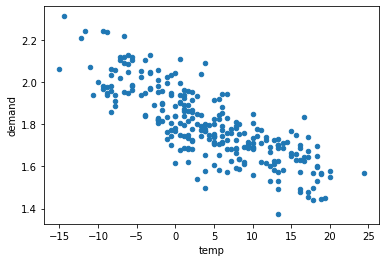

In [78]:
data_winter.plot.scatter("temp", "demand");

- **(4c)** addestrare un modello di regressione con 300 iterazioni di discesa gradiente con lunghezza del passo 0,01
  - non è necessario tenere traccia dei valori intermedi di $\alpha$ e $\beta$

In [79]:
# estrarre i vettori di valori x e y
x = data_winter["temp"].values
y = data_winter["demand"].values
# inizializzare i parametri alpha e beta
alpha = 0
beta = 0
# eseguire 300 iterazioni di discesa gradiente
for i in range(0,300):
    alpha, beta = ulr_gd_step(x, y, alpha, beta, eta)
# creare il modello con i parametri finali
winter_model = make_model(alpha, beta)

- **(4d)** visualizzare il modello estratto sovrapposto ai dati

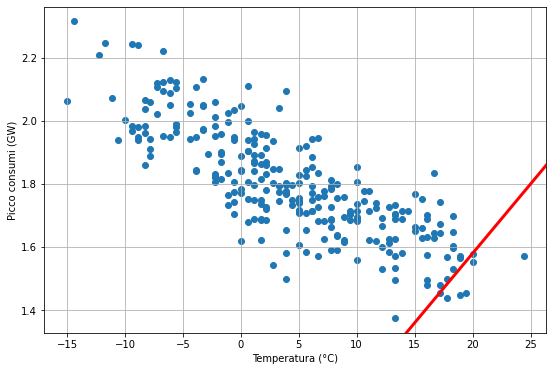

In [80]:
plot_model_on_data(x, y, winter_model)

- **(4e)** usando il modello, prevedere il picco di consumo che si avrebbe con una temperatura di -5 °C

In [81]:
winter_model(-5)

0.47894490586816807

## Caso di studio 2: Predizione valori delle case nei quartieri

- Un'agenzia immobiliare deve **determinare i prezzi ottimali delle case** in vendita
- Un aspetto importante per determinare il prezzo è il quartiere in cui la casa si trova
- Per ogni quartiere si possono individuare delle caratteristiche sommarie
  - dati demografici, posizione, tasse, criminalità, ...
- In base a queste caratteristiche, si vuole determinare il prezzo ideale dell'abitazione "media" di qualsiasi quartiere

### Dati d'esempio

- Il dataset _Housing_, usato in ricerca e disponibile sul Web, contiene informazioni sui quartieri residenziali di Boston
- I dati possono essere reperiti al seguente URL:

In [82]:
housing_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
# il link sopra è quello originale, se non funziona usare quello sotto come alternativa
# housing_url = "https://raw.githubusercontent.com/datascienceunibo/dialab2019/master/Regressione_Lineare/housing.data"

- I dati sono disposti in colonne di larghezza fissa, separate con spazi, senza una riga di intestazione

```
 0.00632  18.00   2.310  0  0.5380  6.5750  65.20  4.0900   1  296.0  15.30 396.90   4.98  24.00
 0.02731   0.00   7.070  0  0.4690  6.4210  78.90  4.9671   2  242.0  17.80 396.90   9.14  21.60
 0.02729   0.00   7.070  0  0.4690  7.1850  61.10  4.9671   2  242.0  17.80 392.83   4.03  34.70
...
```

- Possiamo considerarlo come un CSV dove è usato un numero variabile di spazi come separatore
  - usiamo l'espressione regolare "`\s+`" che indica "uno o più spazi"

In [83]:
housing = pd.read_csv(housing_url, header=None, sep="\\s+")

- Quante righe e colonne contiene il file importato?

In [84]:
housing.shape

(506, 14)

- Non essendoci una riga di header, dobbiamo impostare manualmente i nomi delle colonne
  - `"A B C".split()` è un modo più comodo per ottenere la lista `["A", "B", "C"]`

In [85]:
housing.columns = "CRIM ZN INDUS CHAS NOX RM AGE DIS RAD TAX PTRATIO B LSTAT MEDV".split()

In [86]:
housing.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0,0.458,6.430,58.7,6.0622,3,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0,0.524,6.012,66.6,5.5605,5,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0,0.524,6.172,96.1,5.9505,5,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0,0.524,5.631,100.0,6.0821,5,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0,0.524,6.004,85.9,6.5921,5,311.0,15.2,386.71,17.10,18.9


### Lista delle variabili

- CRIM: tasso di criminalità pro capite per zona
- ZN: proporzione terreno residenziale per lotti maggiori di 25.000 piedi quadrati (circa 2300 m2)
- INDUS: proporzione di acri industriali non commerciali per città
- CHAS: variabile fittizia Charles River, 1 se il tratto affianca il fiume, altrimenti 0
- NOX: concentrazione di ossido d’azoto (parti per 10 milioni)
- RM: numero medio di stanze per abitazione
- AGE: proporzione delle unità abitate costruite prima del 1940
- DIS: distanze pesate verso i cinque uffici di collocamento di Boston
- RAD: indice di accessibilità rispetto alle grandi vie radiali di comunicazione
- TAX: tasso di imposte sulla casa per 10.000 dollari
- PTRATIO: rapporto allievi-docenti per città
- B: 1000(Bk - 0.63)2, dove Bk è la proporzione di persone di origine afroamericana
- LSTAT: percentuale di popolazione con basso reddito
- **MEDV: valore mediano delle abitazioni di proprietà in migliaia di dollari**
  - vogliamo stimare il valore di questa variabile in funzione delle altre

## Regressione lineare multivariata

- Nella regressione multivariata una variabile dipendente è stimata su $n$ variabili indipendenti
- Il modello è rappresentabile come un iperpiano in $n+1$ dimensioni definito da un vettore $\mathbf{\theta}$ di $n+1$ parametri
  - $n$ coefficienti angolari $\theta_1,\ldots,\theta_n$ e l'intercetta $\theta_0$
$$ h(\mathbf{x})=\theta_0+\sum_{i=1}^n\theta_i\cdot x_i $$
- In termini vettoriali, può essere espresso come il prodotto scalare tra il vettore $\mathbf{\theta}$ dei parametri e il vettore $\mathbf{x}$ delle variabili indipendenti con un 1 inserito come primo termine
$$ h(\mathbf{x})=\mathbf{\theta}\cdot([1]\Vert\mathbf{x}) $$
- L'errore quadratico medio di un modello sarà quindi
$$ E = \mathrm{media}\left(\left(h(\mathbf{x})-y\right)^2\right) = \mathrm{media}\left(\left(\mathbf{\theta}\cdot([1]\Vert\mathbf{x})-y\right)^2\right) $$
- Un insieme di $m$ osservazioni su cui addestrare il modello può essere rappresentato da
  - una matrice $\mathbf{X}$ con $m\times n$ valori delle variabili indipendenti
  - un vettore $\mathbf{y}$ con i corrispondenti $m$ valori noti della variabile dipendente

### Dati per la regressione

- Dobbiamo estrarre dai dati caricati la matrice X e il vettore y
- y è dato dalla colonna `MEDV` del frame

In [87]:
y = housing["MEDV"].values

- X è dato dall'intero frame ad esclusione della colonna `MEDV`
  - usiamo il metodo `drop` per ottenere una copia del frame escludendo una o più righe e/o colonne

In [88]:
X = housing.drop(columns=["MEDV"]).values

- Creiamo anche una matrice X1 dove a sinistra di X è aggiunta una colonna di 1
  - `np.c_[A, B, ...]` crea una matrice concatenando le colonne delle matrici A, B, ... date

In [89]:
X1 = np.c_[np.ones((X.shape[0], 1)), X]

### Esempio di modello e inferenza

- Costruiamo ad esempio un modello di regressione che prevede un prezzo fisso per qualsiasi casa
- Creiamo un vettore `theta` con N+1 parametri in cui il parametro 0 è pari al prezzo prefissato e tutti gli altri sono pari a 0, per cui tutte le variabili sono ignorate
- Fissiamo come prezzo fisso la media dei prezzi del dataset

In [90]:
# creo un vettore di zeri di lunghezza 1 + numero di variabili
theta = np.zeros(1 + X.shape[1])

# imposto il parametro 0 (l'intercetta) al prezzo medio di tutte le case
theta[0] = housing["MEDV"].mean()

# stampo il vettore risultante
theta

array([22.53280632,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

- Sia dato un vettore di valori delle variabili indipendenti, ad esempio la prima riga di X (`X[0]`)
- Per calcolare il valore previsto dal modello, sommo il primo valore di `theta` (l'intercetta) al prodotto scalare degli altri con le x

In [91]:
theta[0] + X[0] @ theta[1:]

22.532806324110698

- Equivalentemente posso calcolare il prodotto scalare tra `theta` e il vettore delle `X` con 1 aggiunto

In [92]:
X1[0] @ theta

22.532806324110698

- Per confronto, il valore reale è

In [93]:
y[0]

24.0

- Posso anche sfruttare il prodotto tra matrici e il broadcasting per effettuare predizioni su più casi, ad es. le prime 5 righe del dataset
$$\begin{bmatrix}\cdots&\mathbf{x}_1&\cdots\\&\vdots&\\\cdots&\mathbf{x}_n&\cdots\end{bmatrix}\cdot\begin{bmatrix}\vdots\\\mathbf{\theta}\\\vdots\end{bmatrix}=\begin{bmatrix}\mathbf{x}_1\cdot\mathbf{\theta}\\\vdots\\\mathbf{x}_n\cdot\mathbf{\theta}\end{bmatrix}=\begin{bmatrix}\hat{y}_1\\\vdots\\\hat{y}_n\end{bmatrix}$$

In [94]:
# theta[:, None] = vettore theta convertito a matrice colonna
X1[:5] @ theta[:, None]

array([[22.53280632],
       [22.53280632],
       [22.53280632],
       [22.53280632],
       [22.53280632]])

- Posso semplificare l'espressione sopra a `M @ v`, che restituisce un vettore dei prodotti scalari di ciascuna riga della matrice `M` col vettore `v`

In [95]:
X1[:5] @ theta

array([22.53280632, 22.53280632, 22.53280632, 22.53280632, 22.53280632])

### Discesa del gradiente

- Come sopra implementiamo la discesa gradiente per trovare un modello ottimo, questa volta adattandola al caso multivariato
- Creiamo una funzione `lr_gd_step` modificata rispetto a sopra
  - invece di due parametri `alpha` e `beta` si ha un vettore `theta` di n+1 parametri
  - il calcolo avviene tra matrici
    - `matrice @ vettore` restituisce un vettore dei prodotti scalari di ciascuna riga della matrice col vettore

In [102]:
def lr_gd_step(X1, y, theta, step_size):

    # calcolo l'errore su ciascun dato d'esempio
    #       (y predetta) - y reale
    error = (X1 @ theta) - y

    # calcolo il gradiente dell'errore, ovvero un vettore
    # con le derivate parziali di ciascun parametro
    grad = 2 * (X1.T * error).mean(1)

    # calcolo il nuovo valore di tutti i parametri
    new_theta = theta - step_size * grad
    return new_theta

### Esercizio 5: Regressione multivariata con discesa del gradiente

- **(5a)** Creare un vettore `theta` di parametri del modello inizialmente tutti uguali a 0
- **(5b)** Creare una lista `theta_vals` e inserire il valore iniziale del vettore `theta`
- **(5c)** Eseguire 50 iterazioni di discesa del gradiente con passo 0.000001 (`1e-6`)
- **(5d)** Calcolare il MSE del modello ottenuto in seguito alla discesa del gradiente

In [104]:
theta = np.zeros(X1.shape[1])

In [105]:
theta_vals = [theta]

In [106]:
for iteration in range(50):
    theta = lr_gd_step(X1, y, theta, 0.000001)
    theta_vals.append(theta)

In [107]:
np.mean(np.square(X1 @ theta - y))

81.01326863928051

### Progressione dell'errore

- Dalla progressione dei valori dei parametri, calcoliamo quella del MSE e visualizziamola in un grafico

In [108]:
# converto la lista di vettori theta in una matrice con una riga per ogni iterazione
theta_matrix = np.array(theta_vals)

# estraggo una matrice con l'errore su ogni istanza (righe) ad ogni iterazione (colonne)
errors_by_step = X1 @ theta_matrix.T - y[:, None]

# calcolo il MSE per ogni iterazione
mse_vals = np.mean(np.square(errors_by_step), axis=0)

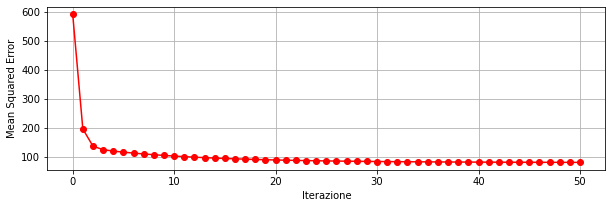

In [110]:
plt.figure(figsize=(10, 3))
plt.plot(mse_vals, "ro-")
plt.grid()
plt.xlabel("Iterazione")
plt.ylabel("Mean Squared Error");

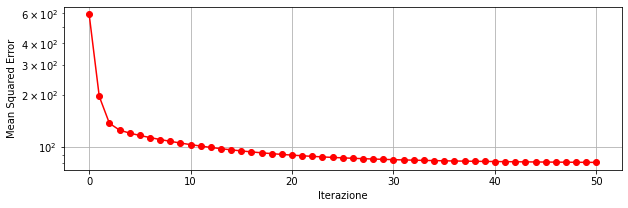

In [111]:
plt.figure(figsize=(10, 3))
plt.semilogy(mse_vals, "ro-")
plt.grid()
plt.xlabel("Iterazione")
plt.ylabel("Mean Squared Error");

- Come prima, l'errore converge gradualmente al valore minimo a cui arriva all'ultima iterazione

### Analisi dei parametri

- Ogni valore del vettore `theta` rappresenta quanto il prezzo aumenta o diminuisce al variare di ciascuno dei parametri
- Per capire quali fenomeni infuiscano positivamente o negativamente, visualizziamo i valori in una serie per associarli ai nomi delle variabili

In [100]:
pd.Series(
    # dati: il vettore dei parametri theta
    theta,
    # etichette: i nomi delle colonne, aggiungendo un nome per l'intercetta
    # e togliendo la variabile dipendente "MEDV"
    index=["theta[0]"] + list(housing.drop(columns=["MEDV"]).columns),
)

theta[0]    22.532806
CRIM         0.000000
ZN           0.000000
INDUS        0.000000
CHAS         0.000000
NOX          0.000000
RM           0.000000
AGE          0.000000
DIS          0.000000
RAD          0.000000
TAX          0.000000
PTRATIO      0.000000
B            0.000000
LSTAT        0.000000
dtype: float64

- Vedendo quali valori sono positivi e quali sono negativi, possiamo dedurre quali fattori facciano aumentare il prezzo e quali lo facciano calare
  - ad es. il prezzo tendenzialmente cala all'aumentare del tasso di criminalità (`CRIM`) ed è più alto per quartieri vicino al fiume (`CHAS`)
- Essendo in scale diverse, è però difficile dire quali variabili influiscano più di altre nella valutazione
  - vedremo in seguito come normalizzare le variabili per risolvere questo problema

## Riepilogo e prossimi laboratori

- Abbiamo visto esempi di modelli di regressione lineare univariata e multivariata per effettuare stime e predizioni su problemi concreti
  - Abbiamo visto come implementare ed usare la discesa gradiente per l'addestramento di tali modelli
- Nei laboratori successivi vedremo come addestrare tali modelli con la libreria scikit-learn
- Una volta introdotta scikit-learn, vedremo come
  - suddividere adeguatamente i dati in set di addestramento e di validazione
  - applicare filtri ai dati, es. normalizzazione
  - addestrare modelli più avanzati rispetto alla regressione lineare

## Esercizi avanzati (opzionali)

- Modificare la procedura della discesa gradiente implementata sopra in modo che
  - si interrompa quando la variazione del MSE da un'iterazione all'altra scenda al di sotto di una determinata soglia (molto piccola, es. $10^{-3}$)
  - la lunghezza del passo si riduca progressivamente ad ogni iterazione